# kaggle 比赛: M5 时序预测

### 项目背景
由预测专家[Spyros Makridakis](https://en.wikipedia.org/wiki/Makridakis_Competitions)组织的M竞赛，旨在通过比较在不同预测方法下解决现实问题的性能，从而更好地理解和改进预测方法。 第一届M比赛于1982年举行。第四届[M4比赛](https://www.sciencedirect.com/science/article/pii/S0169207019301128)于2018年举行，其特色是“ 100,000个时间序列和61种预测方法”。 根据预测研究人员和从业者[Rob Hyndman](https://robjhyndman.com/hyndsight/)所说，“M竞赛对预测领域产生了巨大影响。 他们将注意力集中在哪些模型产生了良好的预测，而不是那些模型的数学特性上。” 这种目的与Kaggle的目标非常相似，后者是最佳的机器学习社区，可以在各种数据集上进行激烈的竞争。 M5是在Kaggle举行的第一场M比赛。

### 项目目标  
本次竞赛的目的为预测零售巨头沃尔玛在未来28天提供的销售数据。除此以外，该数据还进行另一项预测不确定性的比赛，两项比赛的预测期相同，均为28天。

- [预测未来28天销售数据比赛](https://www.kaggle.com/c/m5-forecasting-accuracy/)
- [不确定性预测比赛](https://www.kaggle.com/c/m5-forecasting-uncertainty)

### 数据集
项目要求处理42,840个分层时间序列。 数据是从美国加利福尼亚州（CA）、德克萨斯州（TX）和威斯康星州（WI）3个州获得的。 这里的“分层”表示可以在不同级别上汇总数据：项目级别，部门级别，产品类别级别和州级别。 销售信息从2011年1月开始至2016年6月结束。除了销售数量，数据集还提供了有关价格、促销、节假日的相应数据。  

该数据包含来自3个类别和7个部门的3049种单独产品，分别在3个州的10家商店中销售。对层次进行聚合可以得到这些因素的组合。例如，我们可以为所有销售创建1个时间序列，为每个州所有销售创建3个时间序列，依此类推。 最大的类别是每10个商店的30490时间序列中所有3049个产品的销售额。

- `sales_train_validation.csv`这是主要训练数据。数据集时间从开始2011年1月29日至2016年5月22日，共有1941天；该数据集不包括截至2016年6月19日待预测的28天数据。 它还包括项目，部门，类别，商店和州的ID。 对于30490个项目和10个商店的所有组合，行数为30490。

- `sell_prices.csv`商店、商品ID、每周平均价格。

- `calendar.csv`日期以及相关的分类（例如星期几，月份，年份）和3个二进制列（用于表示每个州的商店在该日期是否允许购买SNAP券）。

- `sample_submission.csv`正确的提交格式。 有关更多信息，请参考[评估选项卡](https://www.kaggle.com/c/m5-forecasting-accuracy/overview/evaluation)。

### 评估指标
- 该预测使用加权均方根比例误差(RMSSE)进行评估，RMSSE由平均绝对比例误差[MASE](https://en.wikipedia.org/wiki/Mean_absolute_scaled_error)演化而来。

# 数据分析
## 加载库

In [2]:
# import libraries
import pandas as pd
import numpy as np
import sys
from  datetime import datetime, timedelta

# import visualization library
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# import machine learning lib
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix
import gc

## 加载和清洗数据
### 数据压缩
> github免费版对上传数据有限制，不能上传大于100MB的文件，需要将原有数据集压缩，压缩格式使用bz2，在此格式下，python可以直接读取数据集。

- Mac OS下，通过Terminal使用以下命令压缩数据集

```shell
$ bzip2 -z sales_train_validation.csv
$ bzip2 -z sell_prices.csv
```

> **注意：使用此命令后会删除被压缩的文件**

### 加载与观察数据

In [3]:
sale_data = pd.read_csv('./m5-forecasting-accuracy/sales_train_validation.bz2')
cal_data = pd.read_csv('./m5-forecasting-accuracy/calendar.csv')
price_data = pd.read_csv('./m5-forecasting-accuracy/sell_prices.bz2')

In [4]:
sale_data.sample(10)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
17039,FOODS_1_186_TX_2_validation,FOODS_1_186,FOODS_1,FOODS,TX_2,TX,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
15727,HOBBIES_2_067_TX_2_validation,HOBBIES_2_067,HOBBIES_2,HOBBIES,TX_2,TX,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
18109,FOODS_3_640_TX_2_validation,FOODS_3_640,FOODS_3,FOODS,TX_2,TX,0,0,0,0,...,0,2,1,0,2,1,0,0,0,2
6842,HOUSEHOLD_1_184_CA_3_validation,HOUSEHOLD_1_184,HOUSEHOLD_1,HOUSEHOLD,CA_3,CA,7,3,6,2,...,2,4,8,3,11,1,2,5,1,3
25716,HOUSEHOLD_2_229_WI_2_validation,HOUSEHOLD_2_229,HOUSEHOLD_2,HOUSEHOLD,WI_2,WI,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
13542,HOUSEHOLD_2_251_TX_1_validation,HOUSEHOLD_2_251,HOUSEHOLD_2,HOUSEHOLD,TX_1,TX,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22162,HOUSEHOLD_1_260_WI_1_validation,HOUSEHOLD_1_260,HOUSEHOLD_1,HOUSEHOLD,WI_1,WI,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
23999,FOODS_3_432_WI_1_validation,FOODS_3_432,FOODS_3,FOODS,WI_1,WI,2,0,2,0,...,2,0,3,0,0,1,0,0,1,0
28464,HOUSEHOLD_1_468_WI_3_validation,HOUSEHOLD_1_468,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0
4581,HOUSEHOLD_2_437_CA_2_validation,HOUSEHOLD_2_437,HOUSEHOLD_2,HOUSEHOLD,CA_2,CA,4,5,1,2,...,4,3,3,0,0,3,1,1,1,1


In [5]:
sale_data.shape

(30490, 1919)

sales_train_validation为历史销售数据，通过该数据获得项目的部门，类别，州和商店ID，d_1至d_1913列为天数，内容为每天的销售额。  
根据比赛说明，需要评估的数据如下：
- d_1914-d_1941共28天数据作为预测的验证行（A榜成绩评估内容）；  
- d_1942-d_1969共28天数据作为最终比赛排名预测的评估行（B榜成绩评估内容）。

**可视化所有商品每天的销量**

In [25]:
# 汇总每天的总销量
day_data = sale_data[[f'd_{day}' for day in range(1,1914)]]
total_sum = np.sum(day_data,axis=0).values

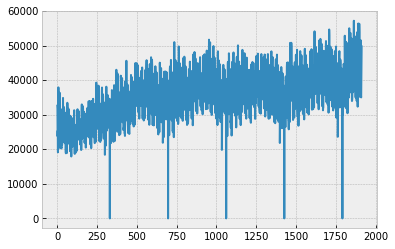

In [7]:
plt.plot(total_sum);

- 销量为0的天数周期性的出现
- 销量异常低的天数周期性的出现
- 销量整体呈增长趋势
- 两个0销量之间的销量趋势类似

**可视化单个商品每天的销量**  
> 选择一个畅销的随机商品，查看其每天的销量的变化

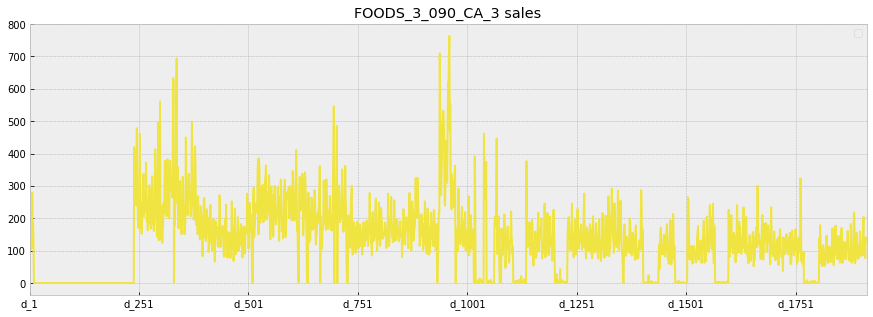

In [54]:
# 获得数据集的所有天数
day_cols = [day for day in sale_data.columns if 'd_' in day]
# 可视化‘FOODS_3_090_CA_3’这个商品每天的销量
sale_data.loc[sale_data['id'] == 'FOODS_3_090_CA_3_validation'] \
    .set_index('id')[day_cols] \
    .T \
    .plot(figsize=(15, 5),
          title='FOODS_3_090_CA_3 sales',
          color=next(color_cycle))
plt.legend('')
plt.show()

In [8]:
# 将实际日期数据与 FOODS_3_090_CA_3 该商品销量数据合并
# 查看需要从日历数据中获取的数据
cal_data[['d','date','event_name_1','event_name_2','event_type_1','event_type_2', 'snap_CA']].sample(5)

,d,date,event_name_1,event_name_2,event_type_1,event_type_2,snap_CA
1496,d_1497,2015-03-05,Purim End,NaN,Religious,NaN,1
1142,d_1143,2014-03-16,Purim End,NaN,Religious,NaN,0
809,d_810,2013-04-17,NaN,NaN,NaN,NaN,0
84,d_85,2011-04-23,NaN,NaN,NaN,NaN,0
1640,d_1641,2015-07-27,NaN,NaN,NaN,NaN,0


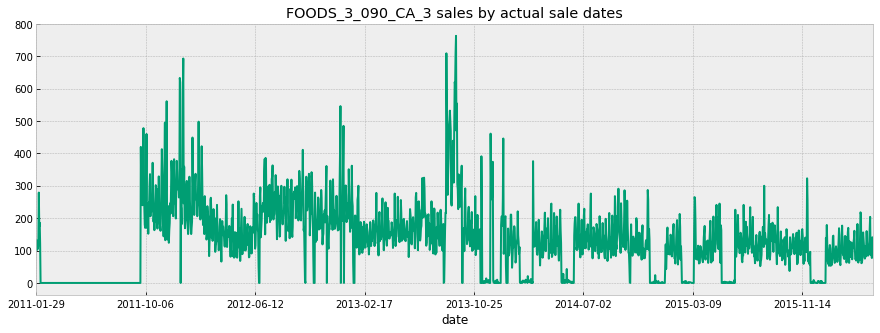

In [53]:
plot_eg_1 = sale_data.loc[sale_data['id'] == 'FOODS_3_090_CA_3_validation'][day_cols].T
plot_eg_1 = plot_eg_1.rename(columns={8412:'FOODS_3_090_CA_3'})
plot_eg_1 = plot_eg_1.reset_index().rename(columns={'index': 'd'}) # 以 d 为索引
plot_eg_1 = plot_eg_1.merge(cal_data)
plot_eg_1.set_index('date')['FOODS_3_090_CA_3'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle),
          title='FOODS_3_090_CA_3 sales by actual sale dates')
plt.show();

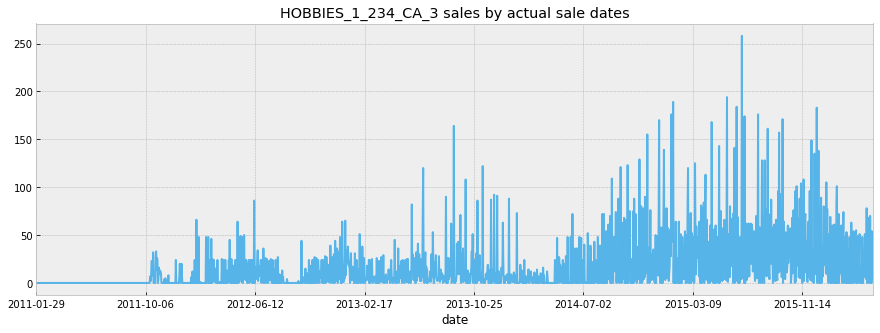

In [52]:
# 与其他畅销商品对比
plot_eg_2 = sale_data.loc[sale_data['id'] == 'HOBBIES_1_234_CA_3_validation'][day_cols].T
plot_eg_2 = plot_eg_2.rename(columns={6324:'HOBBIES_1_234_CA_3'}) # Name it correctly
plot_eg_2 = plot_eg_2.reset_index().rename(columns={'index': 'd'}) # make the index "d"
plot_eg_2 = plot_eg_2.merge(cal_data)
plot_eg_2.set_index('date')['HOBBIES_1_234_CA_3'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle),
          title='HOBBIES_1_234_CA_3 sales by actual sale dates')
plt.show();

- `FOODS_3_090_CA_3_validation`这件商品很畅销
- `HOBBIES_1_234_CA_3`商品销量不高
- `FOODS_3_090_CA_3_validation`在某些情况下几乎没有销量
- `HOBBIES_1_234_CA_3`在某些情况下畅销
- 2011年10月前，2件商品基本没有销量

**查看20种不同商品的销售情况**

In [11]:
# 随机获得20个商品
twenty_egs = sale_data.sample(20, random_state=529) \
    .set_index('id')[day_cols] \
    .T \
    .merge(cal_data.set_index('d')['date'], 
            left_index=True ,
            right_index=True,
            validate='1:1') \
    .set_index('date')

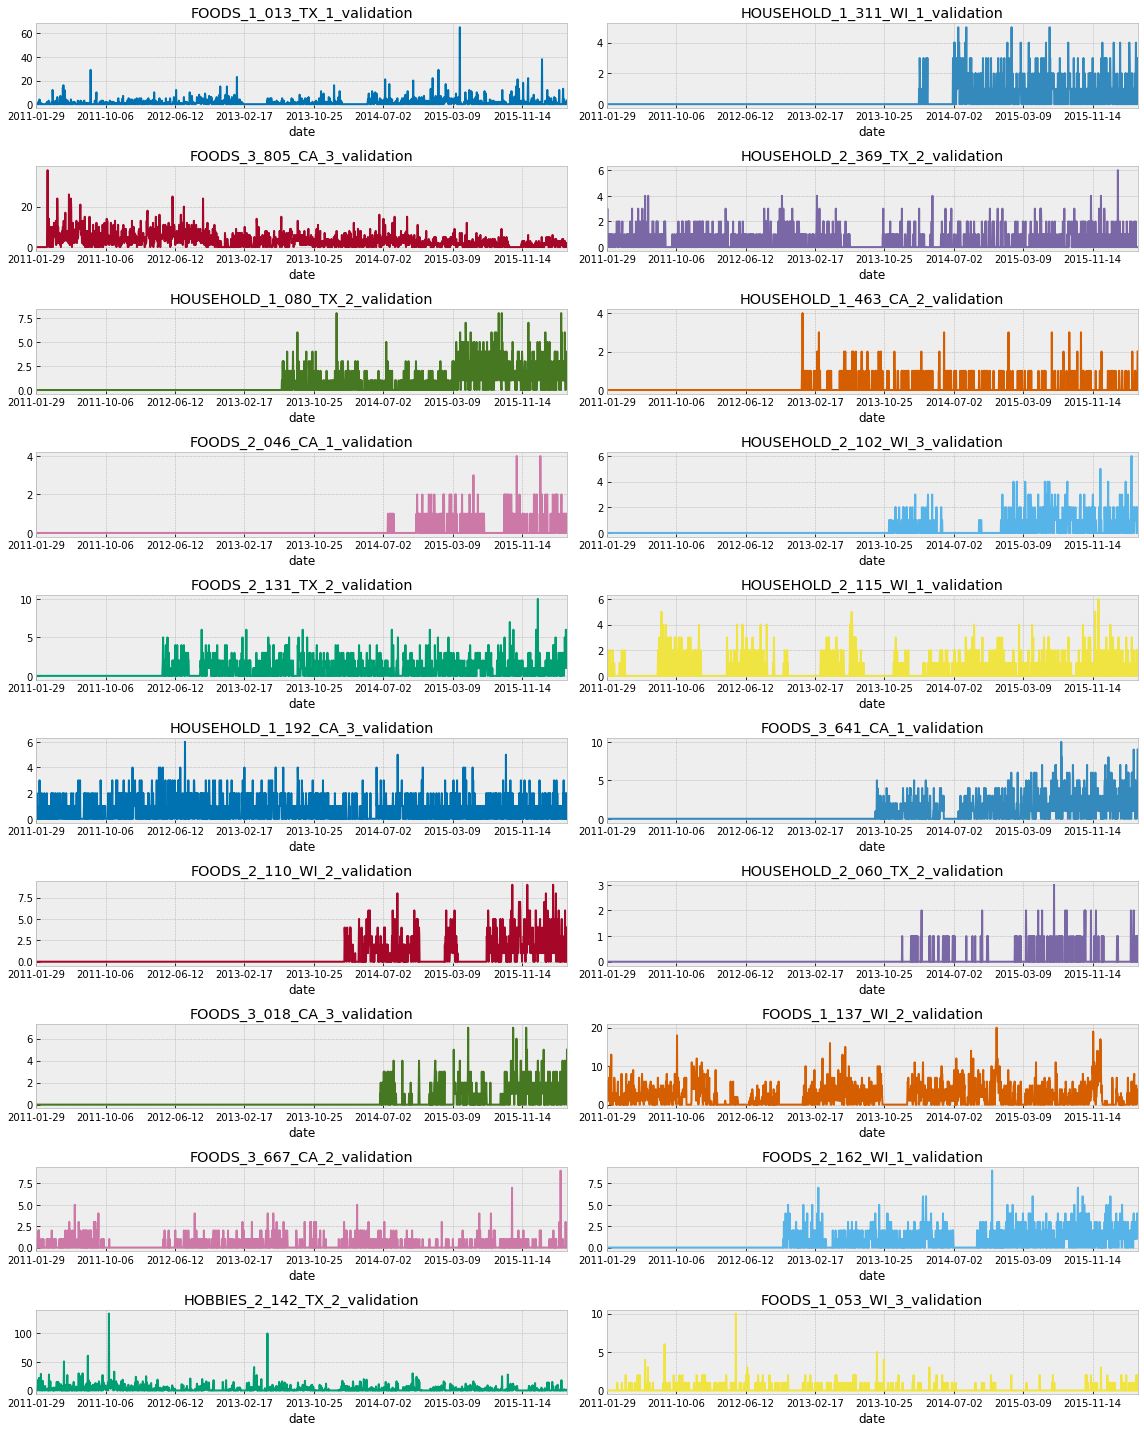

In [67]:
# 生成20种商品的销量图
fig, axs = plt.subplots(10, 2, figsize=(16, 20))
axs = axs.flatten()
ax_idx = 0
for item in twenty_egs.columns:
    twenty_egs[item].plot(title=item,
                        color=next(color_cycle),
                        ax=axs[ax_idx])
    ax_idx += 1
plt.tight_layout()
plt.show()

观察结果：
- 经常会看到一些产品长时间出现销量为0的情况
- 有些商品一天只卖1件或者没有销量，很难预测这些商品未来的销量
- 有些时间段以上所有商品销量均非常高，可能与某些全国性的活动或者节日有关

**按照商品类型分类，观察销量与时间的关系**  

In [14]:
sale_data['cat_id'].unique()

array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object)

数据集中有几种商品类型：  
- 兴趣爱好
- 日常用品
- 食品  

绘制每种类型随着时间，其总销量的变化

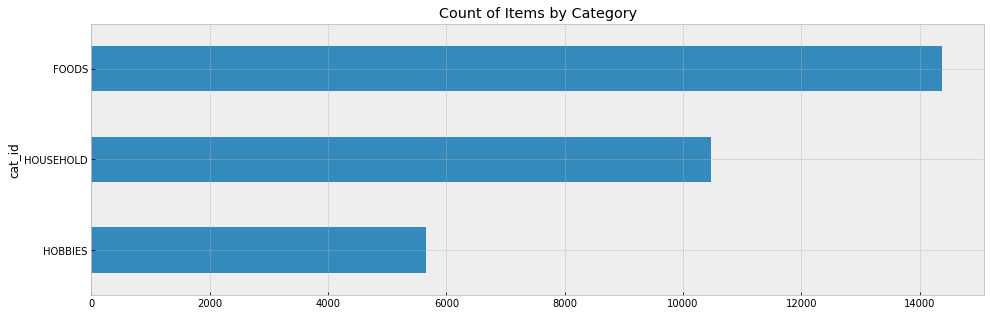

In [23]:
sale_data.groupby('cat_id').count()['id'] \
    .sort_values() \
    .plot(kind='barh', figsize=(16, 5), title='Count of Items by Category')
plt.show()

In [16]:
category_sales = sale_data.set_index('id')[day_cols] \
    .T \
    .merge(cal_data.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')

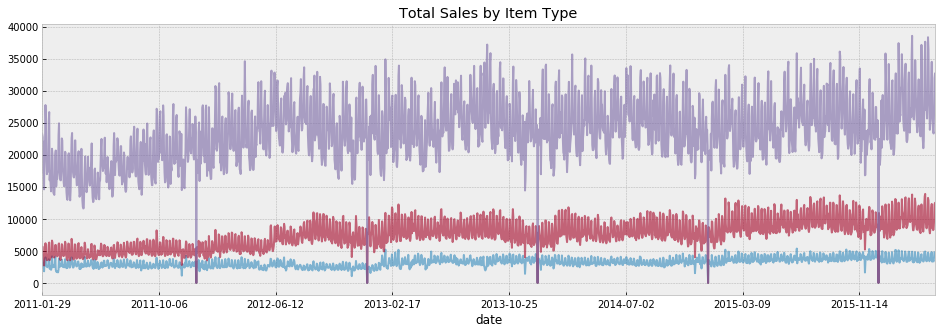

In [51]:
for i in sale_data['cat_id'].unique():
    items_col = [a for a in category_sales.columns if i in a]
    category_sales[items_col] \
        .sum(axis=1) \
        .plot(figsize=(16, 5),
              alpha=0.6,
              title='Total Sales by Item Type')
plt.show()

观察结果：

- 食物分类的商品销量较其他两类，一直保持在最高的水平
- 兴趣爱好分类的商品总销量最低
- 在特定时间段，所有分类的商品销量都有下降，甚至没有销量

**按分店分组，观察销量与时间的关系**

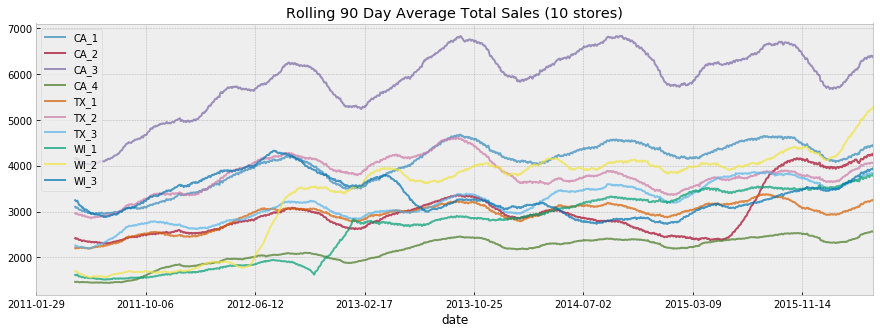

In [50]:
store_list = price_data['store_id'].unique()
for s in store_list:
    store_items = [a for a in category_sales.columns if s in a]
    category_sales[store_items] \
        .sum(axis=1) \
        .rolling(90).mean() \
        .plot(figsize=(15, 5),
              alpha=0.7,
              title='Rolling 90 Day Average Total Sales (10 stores)')
plt.legend(store_list)
plt.show()

观察结果：
- CA_3分店的销量最高
- CA_2、WI_2、WI_1分店销量均在一个时期发生很大波动
- 基本上所有分店总销量均呈增长趋势

**商品`FOODS_3_090`价格与时间的关系**

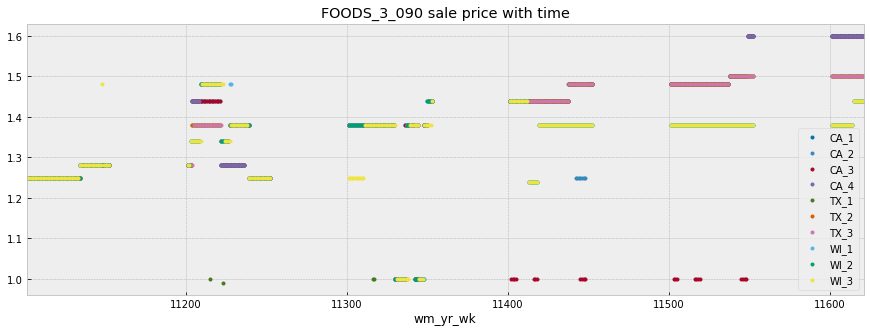

In [75]:
fig, ax = plt.subplots(figsize=(15, 5))
stores = []
for store, d in price_data.query('item_id == "FOODS_3_090"').groupby('store_id'):
    d.plot(x='wm_yr_wk',
          y='sell_price',
          style='.',
          color=next(color_cycle),
          title='FOODS_3_090 sale price with time',
          ax=ax,
          legend=store)
    stores.append(store)
plt.legend(stores)
plt.show()

观察结果：

- 该商品随着时间的推移，价格在逐渐上升
- 有些时间该商品的价格会非常低
- 有些分店在同一时间，该商品价格是不同的

**预测值（label）分布**

In [18]:
# 查看待预测值
day_data.sample(5)

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
4383,0,4,0,0,5,0,0,2,4,0,...,0,6,0,0,0,0,0,0,0,0
20241,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,1,1,0,0
16768,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13549,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26768,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


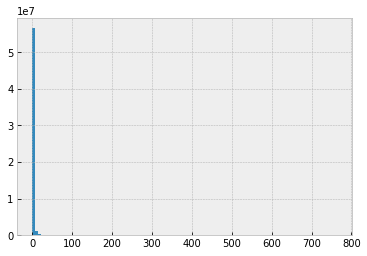

In [54]:
# 为了便于查看分布，转换数据
day_data_single = day_data.values.reshape(-1)
plt.hist(day_data_single,bins=100);

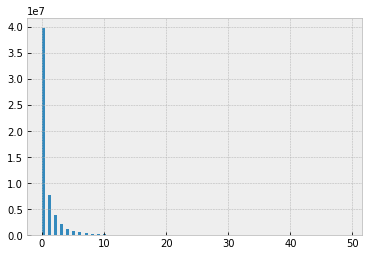

In [55]:
# 小于50的值占大多数，需要增加筛选
plt.hist(day_data_single[day_data_single<50],bins=100);

观察结果：

- 大部分值为0
- 非正态分布

### 数据观察结论

- 所有分店销量呈周期性上升趋势
- 每到圣诞节，所有分店均无销量，故销量为0的天数周期性出现
- 两个0销量之间的销量趋势类似
- 非正态分布，如果不使用自定义模型，使用回归模型时不能使用适合正态分布的模型，如MSE模型
- 食物分类在销量中占比最高，其次是日常用品分类，最后是兴趣爱好分类



---

---
## 二、特征工程

选定机器学习的建模方案，核心思想是对时间序列抽取窗口特征。

抽取窗口特征：

- 前7天
- 前28天
- 前7天均值
- 前28天均值

关联其他维度信息

- 日期
- 价格

In [10]:
# 创建训练数据集
def create_train_data(train_start=750,test_start=1800,is_train=True):
    # 基本参数
    PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }
    CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
            "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
            "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }

    start_day = train_start if is_train else test_start
    numcols = [f"d_{day}" for day in range(start_day,1914)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    SALE_DTYPES = {numcol:"float32" for numcol in numcols} 
    SALE_DTYPES.update({col: "category" for col in catcols if col != "id"})

    # 加载price数据，设置每列数据的类型
    price_data = pd.read_csv('./m5-forecasting-accuracy/sell_prices.bz2',dtype=PRICE_DTYPES)
    # 加载cal数据，设置每列数据的类型
    cal_data = pd.read_csv('./m5-forecasting-accuracy/calendar.csv',dtype=CAL_DTYPES)
    # 加载sale数据，设置每列数据的类型
    sale_data = pd.read_csv('./m5-forecasting-accuracy/sales_train_validation.bz2',dtype=SALE_DTYPES,usecols=catcols+numcols)


    # 类别标签转换
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            price_data[col] = price_data[col].cat.codes.astype("int16")
            price_data[col] -= price_data[col].min()

    cal_data["date"] = pd.to_datetime(cal_data["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal_data[col] = cal_data[col].cat.codes.astype("int16")
            cal_data[col] -= cal_data[col].min()


    for col in catcols:
        if col != "id":
            sale_data[col] = sale_data[col].cat.codes.astype("int16")
            sale_data[col] -= sale_data[col].min()

    # 注意提交格式里有一部分为空
    if not is_train:
        for day in range(1913+1, 1913+ 2*28 +1):
            sale_data[f"d_{day}"] = np.nan

    sale_data = pd.melt(sale_data,
            id_vars = catcols,
            value_vars = [col for col in sale_data.columns if col.startswith("d_")],
            var_name = "d",
            value_name = "sales")
    sale_data = sale_data.merge(cal_data, on= "d", copy = False)
    sale_data = sale_data.merge(price_data, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    return sale_data

In [ ]:
# 创建特征
def create_feature(sale_data, is_train=True, day=None):
    # 可以在这里加入更多的特征抽取方法
    # 获取7天前的数据，28天前的数据
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]

    # 如果是测试集只需要计算一天的特征，减少计算量
    # 注意训练集和测试集特征生成要一致
    if is_train:
        for lag, lag_col in zip(lags, lag_cols):
            sale_data[lag_col] = sale_data[["id","sales"]].groupby("id")["sales"].shift(lag)
    else:
        for lag, lag_col in zip(lags, lag_cols):
            sale_data.loc[sale_data.date == day, lag_col] = sale_data.loc[sale_data.date ==day-timedelta(days=lag), 'sales'].values  


    # 将获取7天前的数据，28天前的数据做移动平均
    wins = [7, 28]

    if is_train:
        for win in wins :
            for lag,lag_col in zip(lags, lag_cols):
                sale_data[f"rmean_{lag}_{win}"] = sale_data[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())
    else:
        for win in wins:
            for lag in lags:
                df_window = sale_data[(sale_data.date <= day-timedelta(days=lag)) & (sale_data.date > day-timedelta(days=lag+win))]
                df_window_grouped = df_window.groupby("id").agg({'sales':'mean'}).reindex(sale_data.loc[sale_data.date==day,'id'])
                sale_data.loc[sale_data.date == day,f"rmean_{lag}_{win}"] = df_window_grouped.sales.values   

    # 处理时间特征
    # 有的时间特征没有，通过datetime的方法自动生成
    date_features = {
            "wday": "weekday",
            "week": "weekofyear",
            "month": "month",
            "quarter": "quarter",
            "year": "year",
            "mday": "day",
        }

    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in sale_data.columns:
            sale_data[date_feat_name] = sale_data[date_feat_name].astype("int16")
        else:
            sale_data[date_feat_name] = getattr(sale_data["date"].dt, date_feat_func).astype("int16")
    return sale_data

In [11]:
sale_data = create_train_data(train_start=350,is_train=True)
sale_data = create_feature(sale_data)

# 清洗数据，选择需要训练的数据
sale_data.dropna(inplace=True)
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
train_cols = sale_data.columns[~sale_data.columns.isin(useless_cols)]
X_train = sale_data[train_cols]
y_train = sale_data["sales"]

In [12]:
X_train.head()

,item_id,dept_id,store_id,cat_id,state_id,wday,month,year,event_name_1,event_type_1,...,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
869062,1,0,0,0,0,6,3,2012,24,3,...,3.97,0.0,0.0,0.000000,0.142857,0.214286,0.214286,10,1,8
869063,1,0,0,0,0,7,3,2012,0,0,...,3.97,0.0,1.0,0.000000,0.142857,0.178571,0.250000,10,1,9
869069,3,0,0,0,0,6,3,2012,24,3,...,4.34,3.0,2.0,1.857143,1.142857,1.392857,1.678571,10,1,8
869070,3,0,0,0,0,7,3,2012,0,0,...,4.34,1.0,0.0,2.000000,1.000000,1.392857,1.607143,10,1,9
869076,4,0,0,0,0,6,3,2012,24,3,...,2.98,0.0,0.0,0.000000,1.857143,0.750000,0.642857,10,1,8


In [13]:
y_train.head()

869062    0.0
869063    0.0
869069    1.0
869070    2.0
869076    0.0
Name: sales, dtype: float32

## 三、模型训练

选择 LGB 模型进行模型的训练。

[LGB安装](https://blog.csdn.net/u011433858/article/details/80402938)

- 损失函数的选择
- 预测时候的技巧

<img src="tweedie.png" style="width:300px;height:200px;float:center">

tweedie_variance_power 参数的选择 [1,2] 之间。

LGB 模型是 GBDT 模型的变种，无法突然训练集的上界。

In [14]:
def train_model(train_data,valid_data):
    params = {
        "objective" : "tweedie",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
        "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
        "metric": ["rmse"],
        "nthread": 8,
        "tweedie_variance_power":1.1,
    'verbosity': 1,
    'num_iterations' : 1500,
    'num_leaves': 128,
    "min_data_in_leaf": 104,
    }

    m_lgb = lgb.train(params, train_data, valid_sets = [valid_data], verbose_eval=50)

    return m_lgb

In [15]:
def predict_ensemble(train_cols,m_lgb):
    date = datetime(2016,4, 25) 
    # alphas = [1.035, 1.03, 1.025, 1.02]
    # alphas = [1.028, 1.023, 1.018]
    alphas = [1.035, 1.03, 1.025]
    weights = [1/len(alphas)]*len(alphas)
    sub = 0.

    test_data = create_train_data(is_train=False)

    for icount, (alpha, weight) in enumerate(zip(alphas, weights)):

        test_data_c = test_data.copy()
        cols = [f"F{i}" for i in range(1,29)]


        for i in range(0, 28):
            day = date + timedelta(days=i)
            print(i, day)
            tst = test_data_c[(test_data_c.date >= day - timedelta(days=57)) & (test_data_c.date <= day)].copy()
            tst = create_feature(tst,is_train=False, day=day)
            tst = tst.loc[tst.date == day , train_cols]

            test_data_c.loc[test_data_c.date == day, "sales"] = alpha*m_lgb.predict(tst)

        # 改为提交数据的格式
        test_sub = test_data_c.loc[test_data_c.date >= date, ["id", "sales"]].copy()
        test_sub["F"] = [f"F{rank}" for rank in test_sub.groupby("id")["id"].cumcount()+1]
        test_sub = test_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
        test_sub.fillna(0., inplace = True)
        test_sub.sort_values("id", inplace = True)
        test_sub.reset_index(drop=True, inplace = True)
        test_sub.to_csv(f"submission_{icount}.csv",index=False)
        if icount == 0 :
            sub = test_sub
            sub[cols] *= weight
        else:
            sub[cols] += test_sub[cols]*weight
        print(icount, alpha, weight)
    
    sub2 = sub.copy()
    # 把大于28天后的validation替换成evaluation
    sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
    sub = pd.concat([sub, sub2], axis=0, sort=False)
    sub.to_csv("submissionV3.csv",index=False)

In [16]:
train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=cat_feats, free_raw_data=False)
valid_inds = np.random.choice(len(X_train), 10000)
valid_data = lgb.Dataset(X_train.iloc[valid_inds], label = y_train.iloc[valid_inds],categorical_feature=cat_feats, free_raw_data=False) 

m_lgb = train_model(train_data,valid_data) 
predict_ensemble(train_cols,m_lgb)

E:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
E:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[50]	valid_0's rmse: 1.89288
[100]	valid_0's rmse: 1.87117
[150]	valid_0's rmse: 1.85433
[200]	valid_0's rmse: 1.84457
[250]	valid_0's rmse: 1.83533
[300]	valid_0's rmse: 1.83204
[350]	valid_0's rmse: 1.82567
[400]	valid_0's rmse: 1.81903
[450]	valid_0's rmse: 1.81652
[500]	valid_0's rmse: 1.81351
[550]	valid_0's rmse: 1.80936
[600]	valid_0's rmse: 1.80451
[650]	valid_0's rmse: 1.79958
[700]	valid_0's rmse: 1.79447
[750]	valid_0's rmse: 1.79519
[800]	valid_0's rmse: 1.79272
[850]	valid_0's rmse: 1.79182
[900]	valid_0's rmse: 1.79094
[950]	valid_0's rmse: 1.78672
[1000]	valid_0's rmse: 1.78261
[1050]	valid_0's rmse: 1.77933
[1100]	valid_0's rmse: 1.77351
[1150]	valid_0's rmse: 1.77149
[1200]	valid_0's rmse: 1.76889
[1250]	valid_0's rmse: 1.76644
[1300]	valid_0's rmse: 1.76537
[1350]	valid_0's rmse: 1.76456
[1400]	valid_0's rmse: 1.7645
[1450]	valid_0's rmse: 1.76364
[1500]	valid_0's rmse: 1.76205
0 2016-04-25 00:00:00
1 2016-04-26 00:00:00
2 2016-04-27 00:00:00
3 2016-04-28 00:00:00
4 2

---
## 四、线下验证

WRMSSE 的评估方法和 RMSE 很不一致，我们需要拆分出么一条时间序列的权重到底是多少，一方面能帮助我们做线下验证，另一方面可以帮助我们思考能否使用自定义的损失函数。

<img src="评估指标.jpg" style="width:500px;height:100px;float:center">


In [17]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix
import gc

# 转换数据类型，减少内存占用空间
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


# 加载数据
data_pass = './m5-forecasting-accuracy/'

# sale数据
sales = pd.read_csv(data_pass+'sales_train_validation.bz2')

# 日期数据
calendar = pd.read_csv(data_pass+'calendar.csv')
calendar = reduce_mem_usage(calendar)

# 价格数据
sell_prices = pd.read_csv(data_pass+'sell_prices.bz2')
sell_prices = reduce_mem_usage(sell_prices)

# 计算价格
# 按照定义，只需要计算最近的 28 天售卖量（售卖数*价格），通过这个可以得到 weight
# 可以不是 1914
cols = ["d_{}".format(i) for i in range(1914-28, 1914)]
data = sales[["id", 'store_id', 'item_id'] + cols]

# 从横表改为纵表
data = data.melt(id_vars=["id", 'store_id', 'item_id'], 
                 var_name="d", value_name="sale")

# 和日期数据做关联
data = pd.merge(data, calendar, how = 'left', 
                left_on = ['d'], right_on = ['d'])

data = data[["id", 'store_id', 'item_id', "sale", "d", "wm_yr_wk"]]

# 和价格数据关联
data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
data.drop(columns = ['wm_yr_wk'], inplace=True)

# 计算售卖量
data['sale_usd'] = data['sale'] * data['sell_price']

# 得到聚合矩阵
# 30490 -> 42840
# 需要聚合的维度明细计算出来
dummies_list = [sales.state_id, sales.store_id, 
                sales.cat_id, sales.dept_id, 
                sales.state_id + sales.cat_id, sales.state_id + sales.dept_id,
                sales.store_id + sales.cat_id, sales.store_id + sales.dept_id, 
                sales.item_id, sales.state_id + sales.item_id, sales.id]


# 全部聚合为一个， 最高 level
dummies_df_list =[pd.DataFrame(np.ones(sales.shape[0]).astype(np.int8), 
                               index=sales.index, columns=['all']).T]

# 挨个计算其他 level 等级聚合
for i, cats in enumerate(dummies_list):
    dummies_df_list +=[pd.get_dummies(cats, drop_first=False, dtype=np.int8).T]
    
# 得到聚合矩阵
roll_mat_df = pd.concat(dummies_df_list, keys=list(range(12)), 
                        names=['level','id'])#.astype(np.int8, copy=False)

# 保存聚合矩阵
roll_index = roll_mat_df.index
roll_mat_csr = csr_matrix(roll_mat_df.values)
roll_mat_df.to_pickle('roll_mat_df.pkl')

# 释放内存
del dummies_df_list, roll_mat_df
gc.collect()


# 按照定义，计算每条时间序列 RMSSE 的权重:
def get_s(drop_days=0):
    
    """
    drop_days: int, equals 0 by default, so S is calculated on all data.
               If equals 28, last 28 days won't be used in calculating S.
    """
    
    # 要计算的时间序列长度
    d_name = ['d_' + str(i+1) for i in range(1913-drop_days)]
    # 得到聚合结果
    sales_train_val = roll_mat_csr * sales[d_name].values

    # 按照定义，前面连续为 0 的不参与计算
    start_no = np.argmax(sales_train_val>0, axis=1)
    
    # 这些连续为 0 的设置为 nan
    flag = np.dot(np.diag(1/(start_no+1)) , np.tile(np.arange(1,1914-drop_days),(roll_mat_csr.shape[0],1)))<1
    sales_train_val = np.where(flag, np.nan, sales_train_val)

    # 根据公式计算每条时间序列 rmsse的权重
    weight1 = np.nansum(np.diff(sales_train_val,axis=1)**2,axis=1)/(1913-start_no-1)
    
    return weight1

S = get_s(drop_days=0)

# 根据定义计算 WRMSSE 的权重，这里指 w 
def get_w(sale_usd):
    """
    """
    # 得到最细维度的每条时间序列的权重
    total_sales_usd = sale_usd.groupby(
        ['id'], sort=False)['sale_usd'].apply(np.sum).values
    
    # 通过聚合矩阵得到不同聚合下的权重
    weight2 = roll_mat_csr * total_sales_usd
    
    return 12*weight2/np.sum(weight2)


W = get_w(data[['id','sale_usd']])

SW = W/np.sqrt(S)

sw_df = pd.DataFrame(np.stack((S, W, SW), axis=-1),index = roll_index,columns=['s','w','sw'])
sw_df.to_pickle('sw_df.pkl')

# 评分函数
# 得到聚合的结果
def rollup(v):
    '''
    '''
    return (v.T*roll_mat_csr.T).T


# 计算 WRMSSE 评估指标
def wrmsse(preds, y_true, score_only=False, s = S, w = W, sw=SW):
    '''
    preds - Predictions: pd.DataFrame of size (30490 rows, N day columns)
    y_true - True values: pd.DataFrame of size (30490 rows, N day columns)
    sequence_length - np.array of size (42840,)
    sales_weight - sales weights based on last 28 days: np.array (42840,)
    '''
    
    if score_only:
        return np.sum(
                np.sqrt(
                    np.mean(
                        np.square(rollup(preds.values-y_true.values))
                            ,axis=1)) * sw *12)
    else: 
        score_matrix = (np.square(rollup(preds.values-y_true.values)) * np.square(w)[:, None]) *12 / s[:, None]
        score = np.sum(np.sqrt(np.mean(score_matrix,axis=1)))
        return score, score_matrix


# 加载前面预先计算好的各个权重
file_pass = './'
sw_df = pd.read_pickle(file_pass+'sw_df.pkl')
S = sw_df.s.values
W = sw_df.w.values
SW = sw_df.sw.values

roll_mat_df = pd.read_pickle(file_pass+'roll_mat_df.pkl')
roll_index = roll_mat_df.index
roll_mat_csr = csr_matrix(roll_mat_df.values)

print(sw_df.loc[(11,slice(None))].sw)

Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to 130.48 Mb (37.5% reduction)
id
FOODS_1_001_CA_1_validation        1.153816e-05
FOODS_1_001_CA_2_validation        7.733063e-06
FOODS_1_001_CA_3_validation        4.491764e-06
FOODS_1_001_CA_4_validation        5.327781e-06
FOODS_1_001_TX_1_validation        3.212428e-07
                                       ...     
HOUSEHOLD_2_516_TX_2_validation    1.611728e-05
HOUSEHOLD_2_516_TX_3_validation    1.675158e-05
HOUSEHOLD_2_516_WI_1_validation    3.829948e-06
HOUSEHOLD_2_516_WI_2_validation    5.996927e-06
HOUSEHOLD_2_516_WI_3_validation    0.000000e+00
Name: sw, Length: 30490, dtype: float64


In [18]:
np.max(sw_df.loc[(11,slice(None))].sw)

0.0004261667790116152